# Predicting County-Level Acute Food Insecurity in Kenya Using Climate, Market, and Conflict Indicators

---

## 1. Business Understanding

This project aims to predict which Kenyan counties are likely to experience **acute food insecurity (IPC Phase 3 or worse)** in upcoming months. Current assessments coordinated under the Integrated Food Security Phase Classification (IPC) primarily describe past conditions, making humanitarian response reactive rather than preventive.

By combining IPC outcomes with rainfall, staple food prices, and conflict events, this project develops a simple **county-level early warning model**. The work supports humanitarian analytics and public policy, targeting NGOs, county governments, and food security planners.

If operationalized, this system could improve early targeting of interventions and resource allocation, aligning with analytical frameworks used by:

- World Food Programme (WFP)  
- Food and Agriculture Organization (FAO)  
- Famine Early Warning Systems Network (FEWS NET)  

---

## 2. Objectives

### Primary Objective

To build a county-level predictive model that estimates the probability of entering **IPC Phase 3+** one month ahead using climate, market, and conflict indicators.

### Secondary Objectives

- Construct a clean county–month panel dataset integrating multiple data sources.
- Identify the most important drivers of acute food insecurity.
- Compare performance of Logistic Regression, Random Forest, and XGBoost models.
- Develop a simple prototype dashboard for visualizing predicted risk.

---

## 3. Problem Statement

Food insecurity monitoring in Kenya largely describes historical conditions using descriptive statistics and post-hoc analysis. There is currently no simple, data-driven system that predicts which counties are likely to enter IPC Phase 3+ in advance.

As a result:

- Humanitarian response is reactive.
- Resources are allocated after crisis onset.
- Early warning signals from climate variability, food price shocks, and instability are not fully integrated into predictive systems.

This project seeks to address this gap by developing a short-term, county-level classification model for IPC Phase 3+ risk.

---

## 4. Data Understanding

The project integrates four primary open-access datasets. To ensure consistency for modeling, I am using **cleaned versions** of these datasets, which have been harmonized into a county-month panel format.

### 4.1 IPC Classifications (Target Variable)

- **Source:** [Integrated Food Security Phase Classification (IPC)](https://www.ipcinfo.org/)
- **Description:** Official county-level acute food insecurity phases.
- **Target Logic:** The original quarterly validity periods have been expanded to monthly frequencies. A binary target is defined as:
    - `1 = IPC Phase ≥ 3` (Crisis or worse)
    - `0 = IPC Phase ≤ 2` (Minimal or Stressed)

### 4.2 Environmental Data (Climate & Vegetation Drivers)

- **Source:** [WFP VAM (Vulnerability Analysis and Mapping)](https://dataviz.vam.wfp.org/)
- **Rainfall Indicators:**
    - `r1q`: 1-month rainfall anomaly ratio (compares current rain to the long-term average).
    - `r3q`: 3-month cumulative rainfall anomaly (captures seasonal drought stress).
- **Vegetation Indicators:**
    - `vim`: Raw NDVI (Normalized Difference Vegetation Index) values, representing absolute greenness/biomass.
    - `viq`: Vegetation Index Quotient, representing vegetation health relative to historical norms.

### 4.3 Food Prices (Market Driver)

- **Source:** [WFP VAM Food Prices / Kenya National Bureau of Statistics](https://price.vam.wfp.org/)
- **Variables:** Monthly maize retail prices (County-level average and monthly percent change).
- **Note:** Maize is utilized as the primary proxy for market-based food access in Kenya.

### 4.4 Conflict Events (Instability Driver)

- **Source:** [ACLED (Armed Conflict Location & Event Data Project)](https://acleddata.com/)
- **Variables:** Monthly county-level counts of `EVENTS` (clashes, protests, etc.) and `FATALITIES`.
- **Note:** This captures local instability that disrupts markets, livelihoods, and humanitarian access.

---

## 5. Data Cleaning and Preprocessing

The following steps were implemented in a separate notebook data_explore.ipynb, to clean individual datasets in preparation for merging:

- **Temporal Alignment:** All features were standardized to a monthly frequency (`YYYY-MM`) and linked to specific Kenyan counties via `PCODE` mapping.
- **Zero-Filling:** For conflict data, months with no recorded activity were filled with `0` to accurately reflect periods of stability.
- **Column Alignment:** Ensured that all datasets had a County and Month column, with County names aligning. 


In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Peak into the cleaned datasets
df_ipc = pd.read_csv('../data/cleaned_ipc_final.csv')
print('IPC dataset:')
print(df_ipc.info())
display(df_ipc.head(5))

df_prices = pd.read_csv('../data/cleaned_food_prices.csv')
print('Food Prices dataset:')
print(df_prices.info())
display(df_prices.head(5))

df_conflict = pd.read_csv('../data/cleaned_conflicts.csv')
print('Conflicts dataset:')
print(df_conflict.info())
display(df_conflict.head(5))

df_rain = pd.read_csv('../data/cleaned_rainfall.csv')
print('Rainfall dataset:')
print(df_rain.info())
display(df_rain.head(5))

df_ndvi = pd.read_csv('../data/cleaned_ndvi.csv')
print('NDVI dataset:')
print(df_ndvi.info())
display(df_ndvi.head(5))


IPC dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2250 non-null   int64  
 1   County      2250 non-null   object 
 2   Month       2250 non-null   object 
 3   IPC         2250 non-null   float64
 4   in_Phase3+  2250 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 88.0+ KB
None


,Unnamed: 0,County,Month,IPC,in_Phase3+
0,0,Baringo,2011-01,1.500000,0
1,1,Baringo,2011-04,1.500000,0
2,2,Baringo,2011-07,1.739130,1
3,3,Baringo,2011-10,1.826087,1
4,4,Baringo,2012-01,1.739130,0


Food Prices dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   County              2096 non-null   object 
 1   Month               2096 non-null   object 
 2   maize_price_per_kg  2096 non-null   float64
 3   price_lag1          2096 non-null   float64
 4   price_lag2          2096 non-null   float64
 5   price_pct_change    2096 non-null   float64
dtypes: float64(4), object(2)
memory usage: 98.4+ KB
None


,County,Month,maize_price_per_kg,price_lag1,price_lag2,price_pct_change
0,Baringo,2015-01,47.0,0.0,0.0,0.000000
1,Baringo,2015-02,47.0,47.0,0.0,0.000000
2,Baringo,2015-03,38.0,47.0,47.0,-0.191489
3,Baringo,2015-04,42.0,38.0,47.0,0.105263
4,Baringo,2015-05,45.0,42.0,38.0,0.071429


Conflicts dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       6204 non-null   object 
 1   County      6204 non-null   object 
 2   Fatalities  6204 non-null   float64
 3   Events      6204 non-null   float64
dtypes: float64(2), object(2)
memory usage: 194.0+ KB
None


,Month,County,Fatalities,Events
0,2015-01,Baringo,1.0,1.0
1,2015-01,Bomet,0.0,2.0
2,2015-01,Bungoma,1.0,1.0
3,2015-01,Busia,0.0,1.0
4,2015-01,Elgeyo Marakwet,0.0,0.0


Rainfall dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   County  6298 non-null   object 
 1   Month   6298 non-null   object 
 2   r3q     6298 non-null   float64
 3   r1q     6298 non-null   float64
dtypes: float64(2), object(2)
memory usage: 196.9+ KB
None


,County,Month,r3q,r1q
0,Baringo,2015-01,83.577607,50.298597
1,Baringo,2015-02,73.369926,54.021410
2,Baringo,2015-03,41.034449,37.700909
3,Baringo,2015-04,84.964367,121.662451
4,Baringo,2015-05,91.392305,90.333584


NDVI dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6298 non-null   int64  
 1   County      6298 non-null   object 
 2   Month       6298 non-null   object 
 3   vim         6298 non-null   float64
 4   viq         6298 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 246.1+ KB
None


,Unnamed: 0,County,Month,vim,viq
0,0,Baringo,2015-01,0.465635,96.461163
1,1,Baringo,2015-02,0.386436,89.878170
2,2,Baringo,2015-03,0.373877,87.666962
3,3,Baringo,2015-04,0.480441,94.466136
4,4,Baringo,2015-05,0.614714,103.892853


## 5.1 Preprocessing (Missed steps)
Align ipc data months with the rest: I need to create a row for each month and add lag features

In [4]:
df_ipc.columns
#drop the 'Unnamed: 0' column from all ndvi and ipc datasets
df_ipc.drop(columns=['Unnamed: 0'], inplace=True)
df_ndvi.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
# remove rows with date earlier than 2015-01 to align with the other datasets
# turn Month column to a datetime object and filter out rows with date earlier than 2015-
df_ipc['Month'] = pd.to_datetime(df_ipc['Month'], format='%Y-%m').dt.to_period('M')
df_ipc = df_ipc.loc[df_ipc['Month'] >= pd.Period('2015-01')].reset_index(drop=True).copy()

# create a complete date range from 2015-01 to 2025-12 and forward fill the missing values for each county
df_ipc = df_ipc.sort_values(['County','Month'])
df_ipc = df_ipc.set_index('Month').groupby(['County']).resample('M').ffill().drop(columns='County').reset_index()

df_ipc.head(20)

,County,Month,IPC,in_Phase3+
0,Baringo,2015-01,1.217391,0
1,Baringo,2015-02,1.217391,0
2,Baringo,2015-03,1.217391,0
3,Baringo,2015-04,1.130435,0
4,Baringo,2015-05,1.130435,0
5,Baringo,2015-06,1.130435,0
6,Baringo,2015-07,1.173913,0
7,Baringo,2015-08,1.173913,0
8,Baringo,2015-09,1.173913,0
9,Baringo,2015-10,1.130435,0


## 5.2 Feature Engineering
To account for the delayed impact of shocks (e.g., a failed rainy season impacting food security months later), we are going to create lag features for: 
ipc, rainfall and 
 I created **1-month, 2-month, and 3-month lags** for rainfall (`r3q`), vegetation (`viq`), and conflict indicators.


In [6]:
# create a function to create lag features for ipc,rainfall,ndvi and conflict datasets
def create_lag_features(df,columns,lags=[1,2,3]):
    df = df.sort_values(['County','Month'])
    for col in columns:
        for i in lags:
            df[f'{col}_lag_{i}'] = df.groupby('County')[col].shift(i)
    return df

In [7]:
# create lag features for ipc, rainfall, ndvi and conflict datasets
df_ipc = create_lag_features(df_ipc,columns=['IPC','in_Phase3+'],lags=[1,2])
df_rain = create_lag_features(df_rain,columns=['r1q','r3q'],lags=[1,2,3])
df_ndvi = create_lag_features(df_ndvi,columns=['vim','viq'],lags=[1,2,3])
df_conflict = create_lag_features(df_conflict,columns=['Fatalities','Events'],lags=[1,2])  

In [8]:
# standardize month column to datetime format in all datasets
datasets = [df_rain, df_ndvi, df_conflict, df_prices]
for df in datasets:
    df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m').dt.to_period('M')

### Merging all datasets to one main dataframe

In [9]:
df_merged = (
    df_ipc
    .merge(df_rain, on=['County','Month'], how='left')
    .merge(df_ndvi, on=['County','Month'], how='left')
    .merge(df_conflict, on=['County','Month'], how='left')
    .merge(df_prices, on=['County','Month'], how='left')    
)

print(df_merged.info())
display(df_merged.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6333 entries, 0 to 6332
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   County              6333 non-null   object   
 1   Month               6333 non-null   period[M]
 2   IPC                 6333 non-null   float64  
 3   in_Phase3+          6333 non-null   int64    
 4   IPC_lag_1           6283 non-null   float64  
 5   IPC_lag_2           6233 non-null   float64  
 6   in_Phase3+_lag_1    6283 non-null   float64  
 7   in_Phase3+_lag_2    6233 non-null   float64  
 8   r3q                 5994 non-null   float64  
 9   r1q                 5994 non-null   float64  
 10  r1q_lag_1           5947 non-null   float64  
 11  r1q_lag_2           5900 non-null   float64  
 12  r1q_lag_3           5853 non-null   float64  
 13  r3q_lag_1           5947 non-null   float64  
 14  r3q_lag_2           5900 non-null   float64  
 15  r3q_lag_3           5

,County,Month,IPC,in_Phase3+,IPC_lag_1,IPC_lag_2,in_Phase3+_lag_1,in_Phase3+_lag_2,r3q,r1q,...,Fatalities,Events,Fatalities_lag_1,Fatalities_lag_2,Events_lag_1,Events_lag_2,maize_price_per_kg,price_lag1,price_lag2,price_pct_change
0,Baringo,2015-01,1.217391,0,NaN,NaN,NaN,NaN,83.577607,50.298597,...,1.0,1.0,NaN,NaN,NaN,NaN,47.0,0.0,0.0,0.000000
1,Baringo,2015-02,1.217391,0,1.217391,NaN,0.0,NaN,73.369926,54.021410,...,1.0,1.0,1.0,NaN,1.0,NaN,47.0,47.0,0.0,0.000000
2,Baringo,2015-03,1.217391,0,1.217391,1.217391,0.0,0.0,41.034449,37.700909,...,0.0,1.0,1.0,1.0,1.0,1.0,38.0,47.0,47.0,-0.191489
3,Baringo,2015-04,1.130435,0,1.217391,1.217391,0.0,0.0,84.964367,121.662451,...,1.0,1.0,0.0,1.0,1.0,1.0,42.0,38.0,47.0,0.105263
4,Baringo,2015-05,1.130435,0,1.130435,1.217391,0.0,0.0,91.392305,90.333584,...,54.0,3.0,1.0,0.0,1.0,1.0,45.0,42.0,38.0,0.071429
5,Baringo,2015-06,1.130435,0,1.130435,1.130435,0.0,0.0,102.741963,97.428593,...,0.0,0.0,54.0,1.0,3.0,1.0,45.0,45.0,42.0,0.000000
6,Baringo,2015-07,1.173913,0,1.130435,1.130435,0.0,0.0,85.348240,69.231878,...,0.0,0.0,0.0,54.0,0.0,3.0,44.0,45.0,45.0,-0.022222
7,Baringo,2015-08,1.173913,0,1.173913,1.130435,0.0,0.0,70.657472,52.892578,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,44.0,45.0,0.000000
8,Baringo,2015-09,1.173913,0,1.173913,1.173913,0.0,0.0,55.285425,50.330213,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,44.0,44.0,0.000000
9,Baringo,2015-10,1.130435,0,1.173913,1.173913,0.0,0.0,57.126571,80.576092,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,44.0,44.0,0.000000


In [10]:
# Create a mapping dictionary for common inconsistencies
county_fix = {
    'Elgeyo Marakwet': 'Elgeyo-Marakwet',
    'Elgeyo-Marakwet East': 'Elgeyo-Marakwet',
    'Kapenguria': 'West Pokot',
    'Tharaka-Nithi': 'Tharaka Nithi',
    'Taita-Taveta': 'Taita Taveta'
}

# Apply to your merged dataframe
df_merged['County'] = df_merged['County'].replace(county_fix)

In [11]:
df_merged.loc[df_merged['maize_price_per_kg'].isna()]['County'].value_counts()

West Pokot         243
Elgeyo-Marakwet    240
Embu               130
Lamu               130
Meru               130
Murang'a           130
Tharaka Nithi      130
Narok              130
Nyeri              130
Taita Taveta       130
Nandi              130
Kiambu             130
Bomet              130
Kisii              130
Kericho            130
Samburu            130
Laikipia           130
Siaya              130
Vihiga             130
Bungoma            130
Nyandarua          130
Kirinyaga          130
Trans Nzoia        130
Nyamira            130
Homa Bay           130
Kwale              130
Kakamega           130
Migori             130
Machakos           130
Busia              130
Makueni            130
Name: County, dtype: int64

# Handling Missing data

In [12]:
# 1. Fill absolute price with the monthly average of all other counties
df_merged['maize_price_per_kg'] = df_merged['maize_price_per_kg'].fillna(
    df_merged.groupby('Month')['maize_price_per_kg'].transform('mean')
)

# 2. Re-calculate the lags and percent change 
# (Because filling the price won't automatically fill the lags)
df_merged['price_lag1'] = df_merged.groupby('County')['maize_price_per_kg'].shift(1)
df_merged['price_lag2'] = df_merged.groupby('County')['maize_price_per_kg'].shift(2)
df_merged['price_pct_change'] = df_merged.groupby('County')['maize_price_per_kg'].pct_change()

In [13]:
# Fill Conflict with 0
conflict_cols = ['Fatalities', 'Events', 'Fatalities_lag_1', 'Events_lag_1', 'Fatalities_lag_2', 'Events_lag_2']
df_merged[conflict_cols] = df_merged[conflict_cols].fillna(0)

# Interpolate Climate per county
climate_cols = ['r1q', 'r3q', 'vim', 'viq', 'r1q_lag_1', 'r3q_lag_1', 'vim_lag_1', 'viq_lag_1']
for col in climate_cols:
    df_merged[col] = df_merged.groupby('County')[col].transform(lambda x: x.interpolate(limit_direction='both'))

In [14]:
df_merged.isna().sum()

County                  0
Month                   0
IPC                     0
in_Phase3+              0
IPC_lag_1              50
IPC_lag_2             100
in_Phase3+_lag_1       50
in_Phase3+_lag_2      100
r3q                     0
r1q                     0
r1q_lag_1               0
r1q_lag_2             433
r1q_lag_3             480
r3q_lag_1               0
r3q_lag_2             433
r3q_lag_3             480
vim                     0
viq                     0
vim_lag_1               0
vim_lag_2             433
vim_lag_3             480
viq_lag_1               0
viq_lag_2             433
viq_lag_3             480
Fatalities              0
Events                  0
Fatalities_lag_1        0
Fatalities_lag_2        0
Events_lag_1            0
Events_lag_2            0
maize_price_per_kg      0
price_lag1             47
price_lag2             94
price_pct_change       47
dtype: int64

In [15]:
# List of columns to re-lag now that the main columns are filled
to_relag = ['r1q', 'r3q', 'vim', 'viq']

for col in to_relag:
    df_merged[f'{col}_lag_1'] = df_merged.groupby('County')[col].shift(1)
    df_merged[f'{col}_lag_2'] = df_merged.groupby('County')[col].shift(2)
    df_merged[f'{col}_lag_3'] = df_merged.groupby('County')[col].shift(3)

# Do the same for Price lags just to be safe
df_merged['price_lag1'] = df_merged.groupby('County')['maize_price_per_kg'].shift(1)
df_merged['price_lag2'] = df_merged.groupby('County')['maize_price_per_kg'].shift(2)

In [16]:
df_merged['price_pct_change'] = df_merged.groupby('County')['maize_price_per_kg'].pct_change()

In [17]:
df_merged.isna().sum()

County                  0
Month                   0
IPC                     0
in_Phase3+              0
IPC_lag_1              50
IPC_lag_2             100
in_Phase3+_lag_1       50
in_Phase3+_lag_2      100
r3q                     0
r1q                     0
r1q_lag_1              47
r1q_lag_2              94
r1q_lag_3             141
r3q_lag_1              47
r3q_lag_2              94
r3q_lag_3             141
vim                     0
viq                     0
vim_lag_1              47
vim_lag_2              94
vim_lag_3             141
viq_lag_1              47
viq_lag_2              94
viq_lag_3             141
Fatalities              0
Events                  0
Fatalities_lag_1        0
Fatalities_lag_2        0
Events_lag_1            0
Events_lag_2            0
maize_price_per_kg      0
price_lag1             47
price_lag2             94
price_pct_change       47
dtype: int64

In [18]:
# Drop rows where the longest lags are still NaN
# Using lag_3 and lag_2 as the 'cutoff'
df_final = df_merged.dropna(subset=['r1q_lag_3', 'viq_lag_3', 'IPC_lag_2', 'price_lag2'])

# Check your final count
print(df_final.isnull().sum())
print(f"Total rows remaining: {len(df_final)}")

County                0
Month                 0
IPC                   0
in_Phase3+            0
IPC_lag_1             0
IPC_lag_2             0
in_Phase3+_lag_1      0
in_Phase3+_lag_2      0
r3q                   0
r1q                   0
r1q_lag_1             0
r1q_lag_2             0
r1q_lag_3             0
r3q_lag_1             0
r3q_lag_2             0
r3q_lag_3             0
vim                   0
viq                   0
vim_lag_1             0
vim_lag_2             0
vim_lag_3             0
viq_lag_1             0
viq_lag_2             0
viq_lag_3             0
Fatalities            0
Events                0
Fatalities_lag_1      0
Fatalities_lag_2      0
Events_lag_1          0
Events_lag_2          0
maize_price_per_kg    0
price_lag1            0
price_lag2            0
price_pct_change      0
dtype: int64
Total rows remaining: 6186


In [19]:
df_final.reset_index(drop=True, inplace=True)

## EDA

### 1. Temporal analysis of Counties in Phase3+ 

<ipython-input-27-d910b5bda8a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Year'] = df_final['Month'].dt.to_timestamp().dt.year


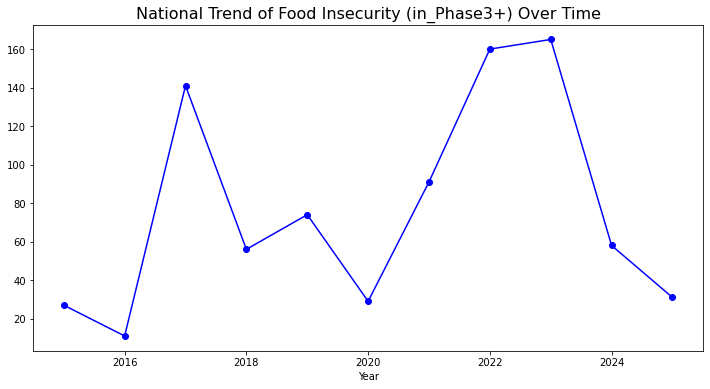

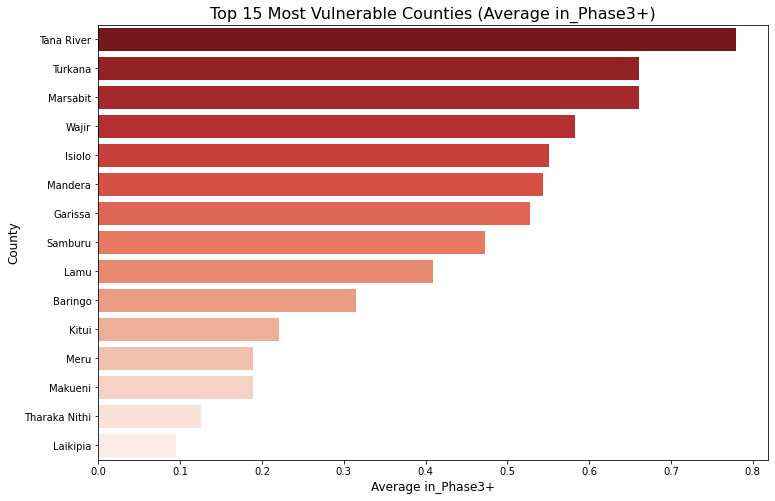

<ipython-input-27-d910b5bda8a1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Month_num'] = df_final['Month'].dt.month


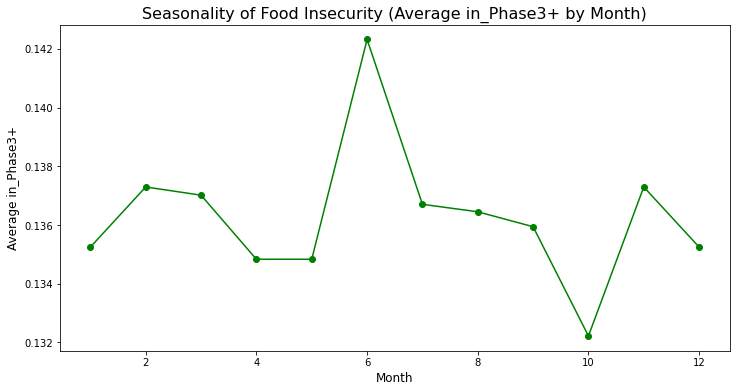

<ipython-input-27-d910b5bda8a1>:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_final, x='Month_num', y='in_Phase3+', color='salmon', ci=None)


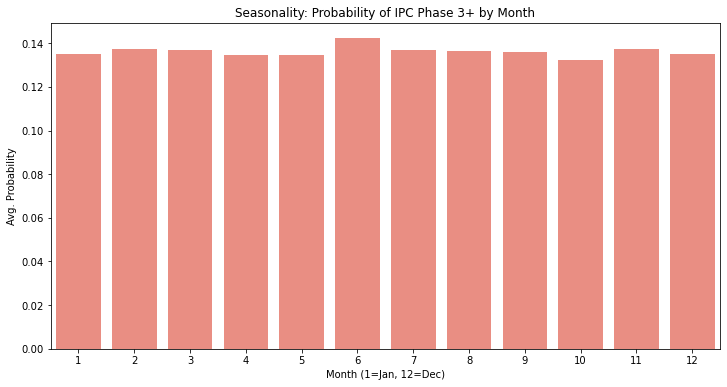

In [ ]:
#National trend of food insecurity over time
df_final['Year'] = df_final['Month'].dt.to_timestamp().dt.year

plt.figure(figsize=(12,6))
national_trend = df_final.groupby(['Year'])['in_Phase3+'].sum()
national_trend.plot(color='blue',marker='o')
plt.title('National Trend of Food Insecurity (in_Phase3+) Over Time', fontsize=16)

# vulnerable counties
plt.figure(figsize=(12,8))
vulnerable_counties = df_final.groupby('County')['in_Phase3+'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=vulnerable_counties.values, y=vulnerable_counties.index, palette='Reds_r')
plt.title('Top 15 Most Vulnerable Counties (Average in_Phase3+)', fontsize=16)
plt.xlabel('Average in_Phase3+', fontsize=12)
plt.ylabel('County', fontsize=12)
plt.show()

# Seasonality analysis
plt.figure(figsize=(12,6))
df_final['Month_num'] = df_final['Month'].dt.month
seasonality = df_final.groupby('Month_num')['in_Phase3+'].mean()
seasonality.plot(color='green', marker='o')
plt.title('Seasonality of Food Insecurity (Average in_Phase3+ by Month)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average in_Phase3+', fontsize=12)
plt.show()


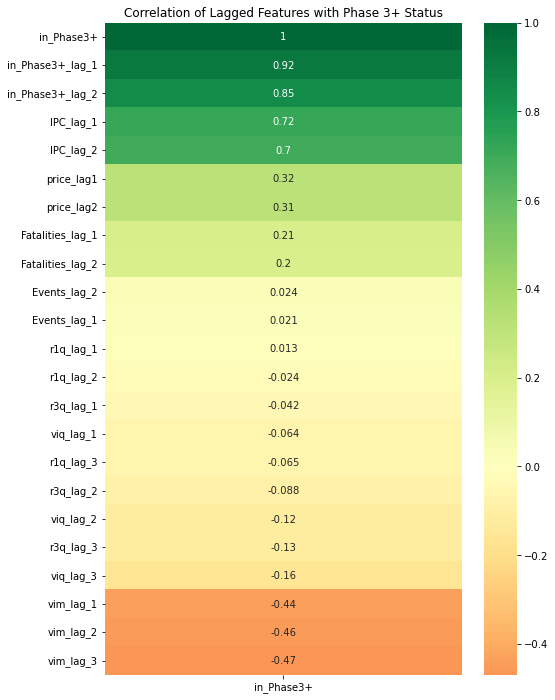

In [28]:

# 1. Select the target and your lagged features
features = [col for col in df_final.columns if 'lag' in col or col == 'in_Phase3+']
corr_matrix = df_final[features].corr()

# 2. Focus specifically on the relationship with the Target
target_corr = corr_matrix[['in_Phase3+']].sort_values(by='in_Phase3+', ascending=False)

# 3. Plot
plt.figure(figsize=(8, 12))
sns.heatmap(target_corr, annot=True, cmap='RdYlGn', center=0)
plt.title("Correlation of Lagged Features with Phase 3+ Status")
plt.show()